# Домашнее задание

* сделать колоризацию фотографий

In [16]:
# params
model_savename = "o2_1_AE_colorization_model.trch"
model_path_without = "/content/drive/MyDrive/Models/"
model_path = model_path_without + model_savename

In [17]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# tqdm -- это маленькая библиотечка для прорисовывания progress bar-ов прямо в питоне
from tqdm import tqdm # один вид
from tqdm import tqdm_notebook # другой вид
from time import sleep

In [18]:
# нужен разнообразный датасет, а не зеленые данные или лица (бежевые)

!wget http://sereja.me/f/universum_compressed.tar
!tar xf universum_compressed.tar

--2022-02-04 07:37:38--  http://sereja.me/f/universum_compressed.tar
Resolving sereja.me (sereja.me)... 213.159.215.132
Connecting to sereja.me (sereja.me)|213.159.215.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72028160 (69M) [application/x-tar]
Saving to: ‘universum_compressed.tar.1’

universum_compresse 100%[===================>]  68.69M  8.35MB/s    in 8.5s    

2022-02-04 07:37:47 (8.08 MB/s) - ‘universum_compressed.tar.1’ saved [72028160/72028160]



In [19]:
import os
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass
                #print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

In [20]:
transform_all = transforms.Compose([
    # вырежем случайный квадратик
    transforms.RandomResizedCrop(128),
    # горизонтально перевернем -- изображение останется валидным
    transforms.RandomRotation(degrees=(-45, 45)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),

    transforms.ToTensor(), # PIL python Image Library преобразует Image в tensor
])

def to_grayscale(x):
    # коэффициенты такие, тк человек на зеленый лучше реагирует
    return (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)

In [21]:
dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 1254/1254 [00:01<00:00, 673.36it/s]


In [22]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        # сеть1, до присоединения чб
        # чб 1канальное -> чб 64канальное
        self.preconcat = nn.Sequential(
            # свертка 1
            nn.Conv2d(1, 32, (3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.LeakyReLU(),

            # свертка 2
            nn.Conv2d(32, 64, (3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.LeakyReLU(),

            # свертка 3
            nn.Conv2d(64, 256, (3, 3), padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.LeakyReLU(),
 
             # развертка 1
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, (3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

             # развертка 2
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, (3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

             # развертка 3
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 64, (3, 3), padding=1),
            nn.LeakyReLU(),
        )
         
        # эту сетку можно особо не увеличивать - она не должна быть очень умной
        # сеть2: сеть1(64канала) + чб 1канальное -> 65канальное
        self.postconcat = nn.Sequential(
            # 65, тк добавляем еще и чб исходное изображение
            nn.Conv2d(65, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        # исходное чб изображение -- просто дополнительным слоем
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

In [23]:
def Block(channels_in, channels_out):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
        # nn.MaxPool2d(),
        # nn.Dropout(),
        # nn.ReLU(),
        # nn.BatchNorm(),
    )

model = nn.Sequential(
    Block(3, 64),
    nn.MaxPool2d((2, 2)),
    Block(64, 128),
    nn.MaxPool2d((2, 2)),
    Block(128, 256),
    Block(256, 256),
    Block(256, 256),
    nn.Upsample(),
    Block(256, 128),
    nn.Upsample(),
    Block(128, 64),
)

In [24]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    torch.nn.init.normal_(m.weight, 0.0, 0.02) # инициализация нормальным распределением
  elif classname.find("BatchNorm") != -1:
    torch.nn.init.normal_(m.weight, 1.0, 0.02)
    torch.nn.init.zeros_(m.bias)

In [25]:
num_epochs = 5000
lr = 4e-3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# создание модели и приминение весов (функция)
model = Colorizer().to(device)
model.apply(weights_init)

# оптимизатор и критерии
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.5, 0.999))
# L1Loss - это среднее, но не всегда это хорошо, мимика у всех разная,
# а среднее по больнице не будет похоже на мимику
criterion = nn.SmoothL1Loss() # поэкспериментировать с loss !!
criterion2 = nn.MSELoss() 
# scheduler - утилита меняет у optimizer lr
# бывают разные, StepLR просто уменьшает lr в gamma раз через step_size эпох
# ReduceLROnPlateau - меняет lr когда модель выходит на плато
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [26]:
# проверка работоспособности модели 1 итерация dataloader
for X, _ in loader:
  print(model(X.cuda()))
  break

tensor([[[[0.5098, 0.5059, 0.5066,  ..., 0.5140, 0.5103, 0.5094],
          [0.5059, 0.5043, 0.5082,  ..., 0.5125, 0.5070, 0.5081],
          [0.5077, 0.5052, 0.5054,  ..., 0.5113, 0.5066, 0.5099],
          ...,
          [0.5134, 0.5135, 0.5076,  ..., 0.5052, 0.5048, 0.5056],
          [0.5129, 0.5163, 0.5149,  ..., 0.5092, 0.5098, 0.5087],
          [0.5158, 0.5190, 0.5177,  ..., 0.5173, 0.5138, 0.5127]],

         [[0.4944, 0.4926, 0.4900,  ..., 0.4958, 0.4953, 0.4951],
          [0.4944, 0.4929, 0.4893,  ..., 0.4916, 0.4886, 0.4960],
          [0.4942, 0.4922, 0.4865,  ..., 0.4897, 0.4851, 0.4960],
          ...,
          [0.4932, 0.4902, 0.4903,  ..., 0.4912, 0.4904, 0.4916],
          [0.4950, 0.4950, 0.4939,  ..., 0.4914, 0.4925, 0.4929],
          [0.4938, 0.4960, 0.4942,  ..., 0.4928, 0.4920, 0.4939]],

         [[0.4985, 0.4928, 0.4906,  ..., 0.4960, 0.4959, 0.4952],
          [0.4975, 0.4907, 0.4910,  ..., 0.4941, 0.4960, 0.4936],
          [0.4977, 0.4934, 0.4922,  ..., 0

In [27]:
def show_img(sample):
  img = sample[1]
  img = img / 2 + 0.5
  npimg = img.numpy()
  npimg = np.clip(npimg, 0., 1.)
  npimg_color = np.transpose(npimg, (1, 2, 0))
  X = sample[0]
  _, H, W = X.shape
  img = np.zeros((H, W, 3))
  img[:,:,1] = img[:,:,2] = img[:,:,0] = X
  f = plt.figure(figsize=(20, 20))
  f.add_subplot(1, 3, 1)
  plt.imshow(img)
  f.add_subplot(1, 3, 2)
  plt.imshow(npimg_color)
  if len(sample) > 2:
    rest = sample[2]
    npimg = rest.numpy()
    npimg = np.clip(npimg, 0., 1.)
    npimg_color = np.transpose(npimg, (1, 2, 0))
    f.add_subplot(1, 3, 3)
    plt.imshow(npimg_color)

  plt.show(block=True)

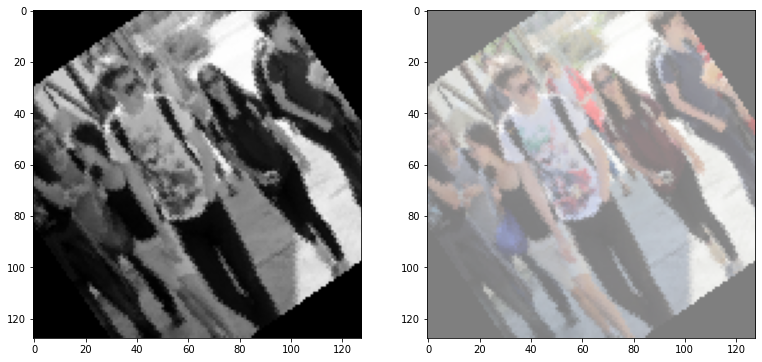

In [28]:
show_img(dataset[0])

In [29]:
!pip install colorama

In [30]:
from colorama import Fore, Back, Style
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

In [31]:
predicting = dataset[0][0].reshape((1,1,128,128)).to(device)

In [32]:
from PIL import Image

In [33]:
mkdir gif

In [34]:
class AverageMeter(object):
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    self.history = []
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count
    self.history.append(self.avg)

  # логгер, передавать info и какой loss был в какой момент
  # def log(self, logger):
  #   logger.info(f"Loss")

  def plot(self):
    plt.plot(self.history)
    plt.show()
  
  def truncate(self, n):
    self.history = self.history[:-(n % len(self.history))]

# load model

In [35]:
from google.colab import drive
# drive.mount('/content/drive')

In [36]:
# Загрузить параметры модели
# model.load_state_dict(torch.load(model_path))

# train

In [37]:
num_epochs = 200

losses = AverageMeter() # умный список
prev = float('inf')
for epoch in range(0, num_epochs):
    # loader = train
    for x, y in loader:
        # 0. распакавать данные на нужное устройство
        x = x.to(device)
        y = y.to(device)
        # 1. сбросить градиент
        optimizer.zero_grad()
        # 2. прогнать данные через сеть
        reconstructed = model(x)
        # 3. посчитать loss
        loss = criterion2(reconstructed, y)
        # 5. сделать .backward()
        loss.backward()
        # 6. optimizer.step()
        optimizer.step()
        # loss.cpu().item() значение loss
        # x.size(0) размерность батча
        losses.update(loss.cpu().item(), x.size(0))
        # xx - батч, поэтому нужно взять какое-то одно изображение
        xx = x[0] # размер: батч, колво каналов, высота, ширина
        yy = y[0]
        rrest = reconstructed[0]
        # каждый раз удаляем изображение, тк места на gpu ограничено
        del reconstructed
        del x
        del y
        # очищает пустые указатели верхнии три из видеопамяти
        torch.cuda.empty_cache()
        # мб garbage collector, чтобы он убирал соответствующие указатели
        # с RAM, но это не критично 

    scheduler.step()
    # приводит модель к нормальному виду, отключает dropout и batchnorm
    model.eval()
    # для гифки недоделано
    tm = model(predicting)[0].detach().cpu() 
    model.train()
    npimg = tm.numpy()
    npimg = np.clip(npimg, 0., 1.)
    npimg_color = np.transpose(npimg, (1, 2, 0))
    Image.fromarray((npimg_color*255).astype(np.uint8)).save(f"gif/{epoch}.png")
    print(f"{b_}Epoch {epoch} \t LR: {scheduler.get_last_lr()}{sr_}")
    if epoch % 5 == 0:
      losses.plot()
      print(f'{g_}Epoch {epoch} of {num_epochs} \n Loss: {losses.avg} \n Iters all: {losses.count}{sr_}')
      # xx - изображение над которым будет происходить преобразование
      # yy - target
      # rrest - то, что было восстановлено
      show_img((xx.detach().cpu(), yy.detach().cpu(), rrest.detach().cpu()))

Output hidden; open in https://colab.research.google.com to view.

In [38]:
def to_numpy_image(img):
    # tl;dr: PyTorch хочет (3, 128, 128), а plt.imshow хочет (128, 128, 3)
    # есть два популярных формата для цветных картинок:
    #  1. где размерность, соответствующая каналам, идёт последней
    #  2. где размерность, соответствующая каналам, идёт первой
    # при работе с нейросетями удобен первый подход -- так запрашиваемая
    # при вычислениях память идёт последовательно, и из-за кэширования
    # операции свёртки работают быстрее
    # второй подход удобнее при уже работе с устройством, которое эти картинки показывает
    # -- удобно на три лампочки послать сразу три последовательно идущих байта
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

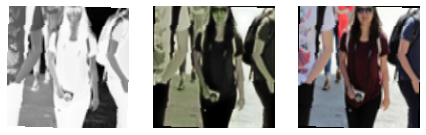

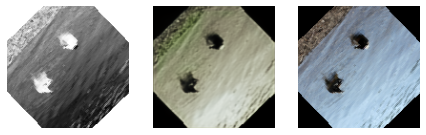

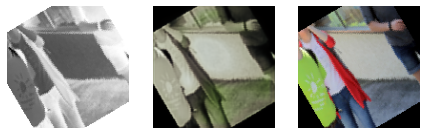

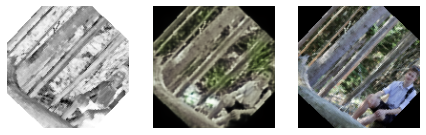

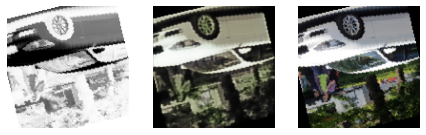

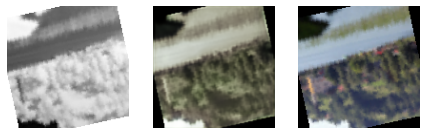

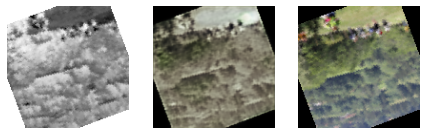

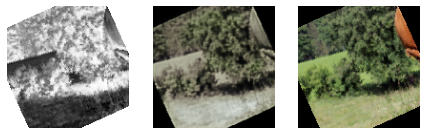

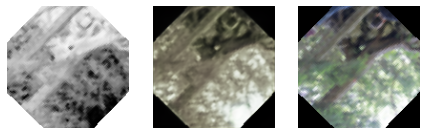

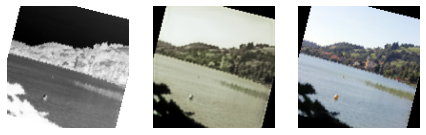

In [39]:
for t in range(10):
    img_gray, img_true = dataset[t]
    img_pred = model(img_gray.to(device).view(1, 1, 128, 128))
    img_pred = to_numpy_image(img_pred)
    # теперь это numpy-евский ndarray размера (128, 128, 3)
    plt.figure(figsize=(10,10))
    
    plt.subplot(141)
    plt.axis('off')
    plt.set_cmap('Greys')
    plt.imshow(img_gray.reshape((128, 128)))

    plt.subplot(142)
    plt.axis('off')
    plt.imshow(img_pred.reshape((128, 128, 3)))

    plt.subplot(143)
    plt.axis('off')
    plt.imshow(to_numpy_image(img_true))
    
    plt.show()

In [40]:
!nvidia-smi

Fri Feb  4 07:52:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    48W / 250W |   3209MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# save model

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
'/content/drive/MyDrive/Базы/googleplaystore.csv'

'/content/drive/MyDrive/Базы/googleplaystore.csv'

In [43]:
# Сохранить параметры модели
# torch.save(model.state_dict(), model_path_without)

# Другие эксперименты

In [44]:
# эксперимент с ResNet (не работает)
# resnet в pytorch хранится как модель, поэтому можно обращаться на прямую к слоям
# 

import torchvision.models as models

class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(num_classes=365)
        # параметризуем, чтобы на вход подавалось ч/б изображение
        # схлопываем веса первой свертки в один канал
        resnet.conv1.weights = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
        self.preconcat = nn.Sequential(
            # * разыменовали
            nn.Sequential(*list(resnet.children())[0:6]),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2),
        )
         
        self.postconcat = nn.Sequential(
            # 65, тк добавляем еще и чб исходное изображение
            nn.Conv2d(65, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        # исходное чб изображение -- просто дополнительным слоем
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

In [47]:
num_epochs = 200
lr = 4e-3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# создание модели и приминение весов (функция)
model = Colorizer().to(device)
model.apply(weights_init)

# оптимизатор и критерии
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.5, 0.999))
# L1Loss - это среднее, но не всегда это хорошо, мимика у всех разная,
# а среднее по больнице не будет похоже на мимику
criterion = nn.SmoothL1Loss() # поэкспериментировать с loss !!
criterion2 = nn.MSELoss() 
# scheduler - утилита меняет у optimizer lr
# бывают разные, StepLR просто уменьшает lr в gamma раз через step_size эпох
# ReduceLROnPlateau - меняет lr когда модель выходит на плато
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [ ]:
num_epochs = 200

losses = AverageMeter() # умный список
prev = float('inf')
for epoch in range(0, num_epochs):
    # loader = train
    for x, y in loader:
        # 0. распакавать данные на нужное устройство
        x = x.to(device)
        y = y.to(device)
        # 1. сбросить градиент
        optimizer.zero_grad()
        # 2. прогнать данные через сеть
        reconstructed = model(x)
        # 3. посчитать loss
        loss = criterion2(reconstructed, y)
        # 5. сделать .backward()
        loss.backward()
        # 6. optimizer.step()
        optimizer.step()
        # loss.cpu().item() значение loss
        # x.size(0) размерность батча
        losses.update(loss.cpu().item(), x.size(0))
        # xx - батч, поэтому нужно взять какое-то одно изображение
        xx = x[0] # размер: батч, колво каналов, высота, ширина
        yy = y[0]
        rrest = reconstructed[0]
        # каждый раз удаляем изображение, тк места на gpu ограничено
        del reconstructed
        del x
        del y
        # очищает пустые указатели верхнии три из видеопамяти
        torch.cuda.empty_cache()
        # мб garbage collector, чтобы он убирал соответствующие указатели
        # с RAM, но это не критично 

    scheduler.step()
    model.eval()
    tm = model(predicting)[0].detach().cpu()
    model.train()
    npimg = tm.numpy()
    npimg = np.clip(npimg, 0., 1.)
    npimg_color = np.transpose(npimg, (1, 2, 0))
    Image.fromarray((npimg_color*255).astype(np.uint8)).save(f"gif/{epoch}.png")
    print(f"{b_}Epoch {epoch} \t LR: {scheduler.get_last_lr()}{sr_}")
    if epoch % 5 == 0:
      losses.plot()
      print(f'{g_}Epoch {epoch} of {num_epochs} \n Loss: {losses.avg} \n Iters all: {losses.count}')
      # xx - изображение над которым будет происходить преобразование
      # yy - target
      # rrest - то, что было восстановлено
      show_img((xx.detach().cpu(), yy.detach().cpu(), rrest.detach().cpu()))

# Выводы:
1. Сделал колоризацию фотографий. Учитывая, что не были использованы предобученные сети unet, resnet и другие, а также не были использованы ганы, результат получился хороший.